In [1]:
import pandas as pd
from typing import Dict, Any, Union, Optional
import json

In [2]:
def _flatten_query(q: Dict[str, Any]) -> Optional[Dict[str, int]]:
    if "index_winner" not in q:
        return None
    sent = {
        d["label"] if d["label"] != "center" else "head": d["index"]
        for d in q["target_indices"]
    }
    t = q["timestamp_query_generated"]
    dt = q["response_time"]
    label = q["alg_label"]
    return {
        "winner": q["index_winner"],
        "alg": label,
        "response_time": dt,
        "puid": q["participant_uid"].split("_")[-1],
        **sent,
    }


import zipfile
def _munge(fname: str) -> pd.DataFrame:
    if "zip" in fname:
        with zipfile.ZipFile(fname) as zf:
            assert len(zf.filelist) == 1, "Only specify one file in zip file"
            fname = zf.filelist[0]
            raw = json.loads(zf.read(fname))
    else:
        with open(fname, "r") as f:
            raw = json.load(f)

    assert raw.pop("meta") == {"status": "OK", "code": 200}
    assert len(raw) == 1
    rare = raw["participant_responses"]
    for k, v in rare.items():
        for vi in v:
            vi["puid"] = k
    mrare = sum(rare.values(), [])
    medium = [_flatten_query(d) for d in mrare]
    mwell = [m for m in medium if m]
    df = pd.DataFrame(mwell)
    cols = ["head", "left", "right", "winner", "alg", "response_time", "puid"]
    assert set(df.columns) == set(cols)
    df["loser"] = df[["head", "left", "right", "winner"]].apply(
        lambda r: r["left"] if r["winner"] == r["right"] else r["right"], axis=1
    )
    return df[cols + ["loser"]]

In [3]:
fnames = [
    (0, "i0126.png"), (1, "i0208.png"), (2, "i0076.png"), (3, "i0326.png"),
    (4, "i0526.png"), (5, "i0322.png"), (6, "i0312.png"), (7, "i0036.png"),
    (8, "i0414.png"), (9, "i0256.png"), (10, "i0074.png"), (11, "i0050.png"),
    (12, "i0470.png"), (13, "i0022.png"), (14, "i0430.png"), (15, "i0254.png"),
    (16, "i0572.png"), (17, "i0200.png"), (18, "i0524.png"), (19, "i0220.png"),
    (20, "i0438.png"), (21, "i0454.png"), (22, "i0112.png"), (23, "i0494.png"),
    (24, "i0194.png"), (25, "i0152.png"), (26, "i0420.png"), (27, "i0142.png"),
    (28, "i0114.png"), (29, "i0184.png"),
]
smoothness = {idx: int(target.strip("i.png")) for idx, target in fnames}

In [4]:
df = _munge("_io/next-fig3.json.zip")
df = df[df.alg == "RandomSampling"]
for col in ["head", "left", "right", "winner", "loser"]:
    df[f"{col}_x"] = df[col].apply(smoothness.get)
df.head()

,head,left,right,winner,alg,response_time,puid,loser,head_x,left_x,right_x,winner_x,loser_x
0,11,15,28,28,RandomSampling,7.262,7yKPDsCJpBfI2oiKWVMk48pWJ851po,15,50,254,114,114,254
4,9,15,25,25,RandomSampling,1.742,7yKPDsCJpBfI2oiKWVMk48pWJ851po,15,256,254,152,152,254
22,20,8,22,8,RandomSampling,1.613,7yKPDsCJpBfI2oiKWVMk48pWJ851po,22,438,414,112,414,112
25,15,3,16,3,RandomSampling,1.251,7yKPDsCJpBfI2oiKWVMk48pWJ851po,16,254,326,572,326,572
26,21,29,0,0,RandomSampling,2.233,7yKPDsCJpBfI2oiKWVMk48pWJ851po,29,454,184,126,126,184


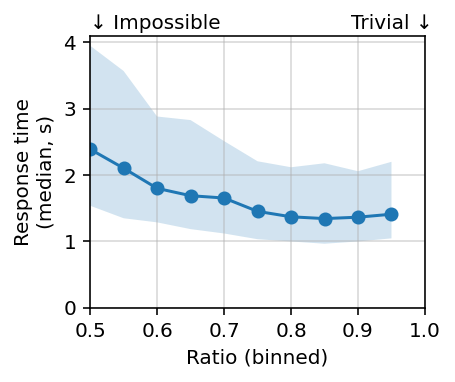

In [6]:
import numpy as np
import matplotlib.pyplot as plt
df["Dl"] = np.abs(df["head_x"] - df["left_x"])
df["Dr"] = np.abs(df["head_x"] - df["right_x"])

df["difficulty"] = np.maximum(df["Dl"], df["Dr"]) / (df["Dl"] + df["Dr"])

df["response_time_binned"] = np.round(df["response_time"], 1)
df["difficulty_binned"] = (df["difficulty"] * 20).astype(int) / 20

w = 2.5
fig, ax = plt.subplots(figsize=(1.2 * w, w))
kwargs = dict(
    index="difficulty_binned",
    values="response_time",
)
middle = df.pivot_table(**kwargs,  aggfunc="median")
lower = df.pivot_table(**kwargs,  aggfunc=lambda x: np.percentile(x, 25))
upper = df.pivot_table(**kwargs,  aggfunc=lambda x: np.percentile(x, 75))

middle.plot(ax=ax, style="o-")

ax.fill_between(lower.index, lower.values.flatten(), upper.values.flatten(), alpha=0.2)

ax.grid(alpha=0.5)
ax.set_ylabel("Response time\n(median, s)")
ax.set_xlabel("Ratio (binned)")
ax.set_xlim(0.5, 1)
ax.legend_.remove()
ax.text(0.5, 4.2, "↓ Impossible")
ax.text(0.89, 4.2, "Trivial ↓")
ax.set_ylim(0, None)

fig.savefig("figures/response_time.png", transparent=True, bbox_inches="tight", dpi=300)

In [7]:
correct = np.abs(df["head_x"] - df["winner_x"]) < np.abs(df["head_x"] - df["loser_x"])
df["correct"] = correct
df["correct"]

0         True
4        False
22        True
25        True
26       False
         ...  
20070     True
20076     True
20083    False
20084     True
20085     True
Name: correct, Length: 4092, dtype: bool

Easy questions (ratio$> 0.75$)


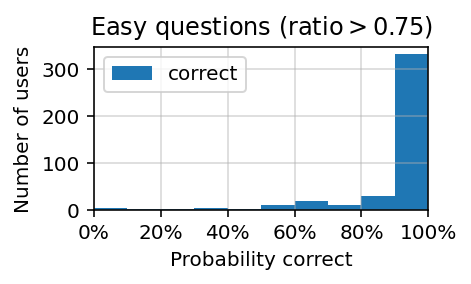

In [12]:
df["difficulty_binned"] = (df["difficulty"] * 5).astype(int) / 5
df["difficulty_label"] = ""

divs = (0.55, 0.75)
idx = (0.5 <= df["difficulty"]) & (df["difficulty"] < divs[0])
df.loc[idx, "difficulty_label"] = "hard"
idx = (divs[0] <= df["difficulty"]) & (df["difficulty"] < divs[1])
df.loc[idx, "difficulty_label"] = "medium"
idx = (divs[1] <= df["difficulty"]) & (df["difficulty"] < 1)
df.loc[idx, "difficulty_label"] = "easy"
assert (df["difficulty_label"] == "").sum() == 0


w = 1.5
fig, ax = plt.subplots(figsize=(2 * w, w))
ax = df[df.difficulty_label == "easy"].pivot_table(
    index="puid",
    values="correct",
    aggfunc="mean",
).plot.hist(ax=ax)
ax.set_xlabel("Probability correct")
title = f"Easy questions (ratio" + r"$> " + str(divs[1]) + "$)"
print(title)
ax.set_title(title)
ax.set_ylabel("Number of users")
ax.set_xlim(0, 1)
ax.grid(alpha=0.5)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x * 100)}%"))
fig.savefig("figures/prob-correct.png", dpi=300, bbox_inches="tight", transparent=True)